In [1]:
import pandas as pd
df = pd.read_csv("C:/Users/seonahryu/Desktop/urp/combined_data.csv", index_col='date')

-1~1 정규화

In [2]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
features_to_scale = ['past_day_close', 'Open', 'High', 'Low', 'Volume', 'Adj Close'] # nasdaq 지수만 정규화

scaler = MinMaxScaler(feature_range=(-1,1))
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print(df.head(10))

                                                         text  \
date                                                            
2009-05-05  Donald Trump will be appearing on The View tom...   
2009-05-08  Donald Trump reads Top Ten Financial Tips on L...   
2009-05-09  New Blog Post: Celebrity Apprentice Finale and...   
2009-05-12  """My persona will never be that of a wallflow...   
2009-05-12  "Miss USA Tara Conner will not be fired - ""I'...   
2009-05-13  Listen to an interview with Donald Trump discu...   
2009-05-14  """Strive for wholeness and keep your sense of...   
2009-05-15  "Enter the ""Think Like A Champion"" signed bo...   
2009-05-19  """...these days...we could all use a little o...   
2009-05-20  """Always know you could be on the precipice o...   

            vader_sentiment  roberta_sentiment  past_day_close      Open  \
date                                                                       
2009-05-05                1                  0       -0.989263 -0.9

sentiment 범위 확인

In [3]:
# 최대값과 최소값 계산
vader_max = df['vader_sentiment'].max()
vader_min = df['vader_sentiment'].min()
roberta_max = df['roberta_sentiment'].max()
roberta_min = df['roberta_sentiment'].min()

# 결과 출력
print(f"VADER Sentiment - 최대값: {vader_max}, 최소값: {vader_min}")
print(f"Roberta Sentiment - 최대값: {roberta_max}, 최소값: {roberta_min}")

VADER Sentiment - 최대값: 1, 최소값: -1
Roberta Sentiment - 최대값: 1, 최소값: -1


# LSTM

In [4]:
import numpy as np

# 데이터셋 생성 함수 정의
def create_dataset(X, y, time_step=30):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

# 예측 및 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    return mse, rmse, r_squared

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# LSTM 모델 정의
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input 레이어 추가
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='tanh'))  # -1~1 정규화해서 출력층 tanh 함수
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

input : VADER

In [6]:
from sklearn.model_selection import train_test_split

vader = ['vader_sentiment']

X, y = create_dataset(df[vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [14]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Batch Size: 32, MSE: 0.234, RMSE: 0.484, R-squared: -0.001
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Batch Size: 64, MSE: 0.234, RMSE: 0.484, R-squared: -0.000
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Batch Size: 128, MSE: 0.234, RMSE: 0.484, R-squared: -0.000
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Batch Size: 256, MSE: 0.234, RMSE: 0.484, R-squared: -0.000
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Batch Size: 512, MSE: 0.234, RMSE: 0.484, R-squared: -0.000
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Batch Size: 1024, MSE: 0.234, RMSE: 0.483, R-squared: 0.000


In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : RoBERTa

In [ ]:
from sklearn.model_selection import train_test_split

roberta = ['roberta_sentiment']

X, y = create_dataset(df[roberta].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : VADER + RoBERTa

In [ ]:
from sklearn.model_selection import train_test_split

sentiment = ['vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close

In [25]:
from sklearn.model_selection import train_test_split

past_day_close = ['past_day_close']

X, y = create_dataset(df[past_day_close].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Batch Size: 32, MSE: 0.011, RMSE: 0.103, R-squared: 0.857
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Batch Size: 64, MSE: 0.012, RMSE: 0.108, R-squared: 0.845
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Batch Size: 128, MSE: 0.012, RMSE: 0.108, R-squared: 0.843
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Batch Size: 256, MSE: 0.031, RMSE: 0.175, R-squared: 0.590
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Batch Size: 512, MSE: 0.024, RMSE: 0.156, R-squared: 0.673
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Batch Size: 1024, MSE: 0.006, RMSE: 0.075, R-squared: 0.924


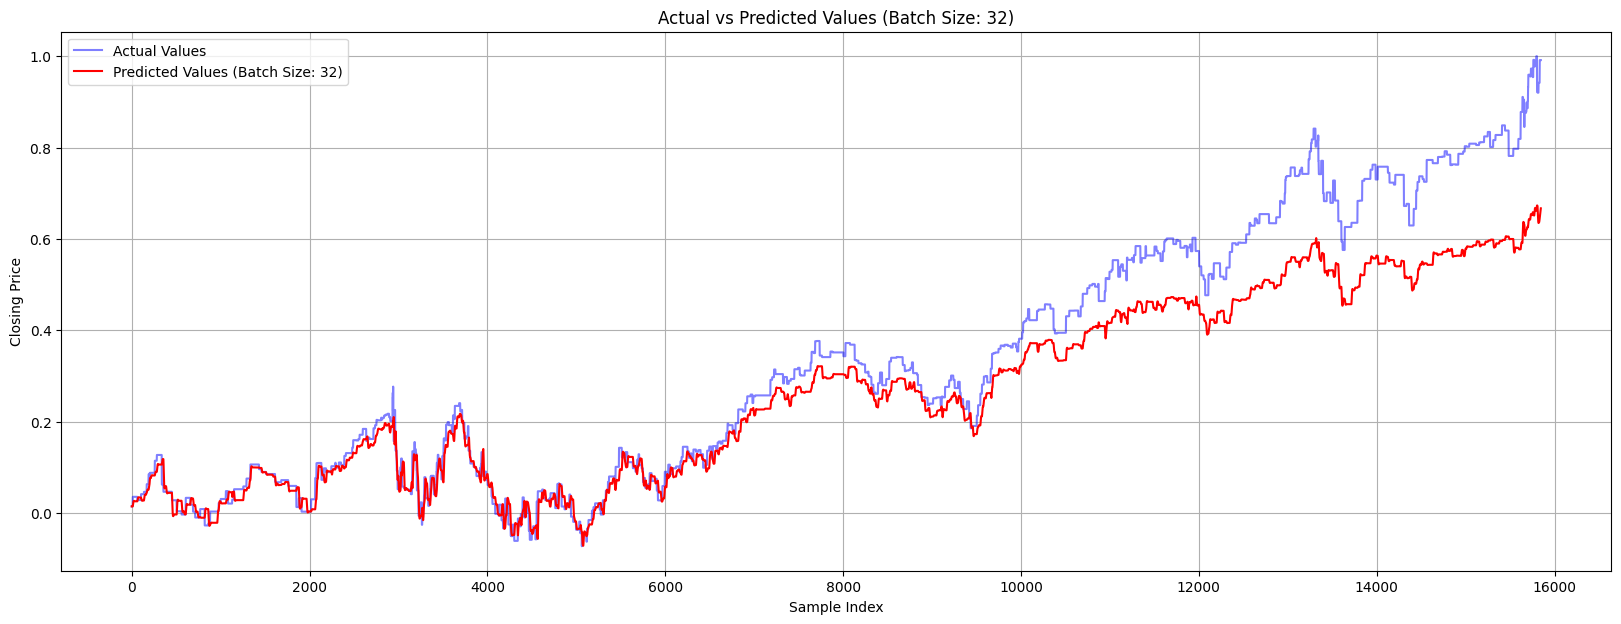

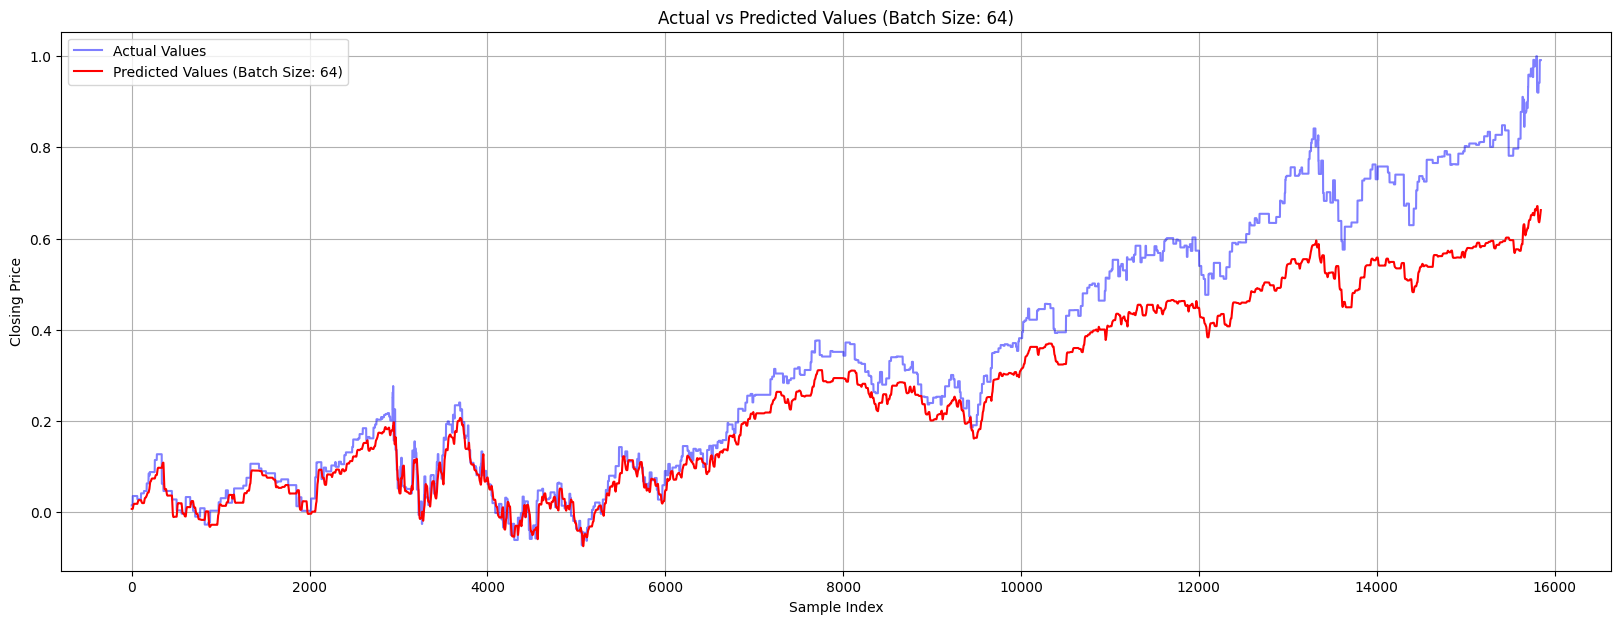

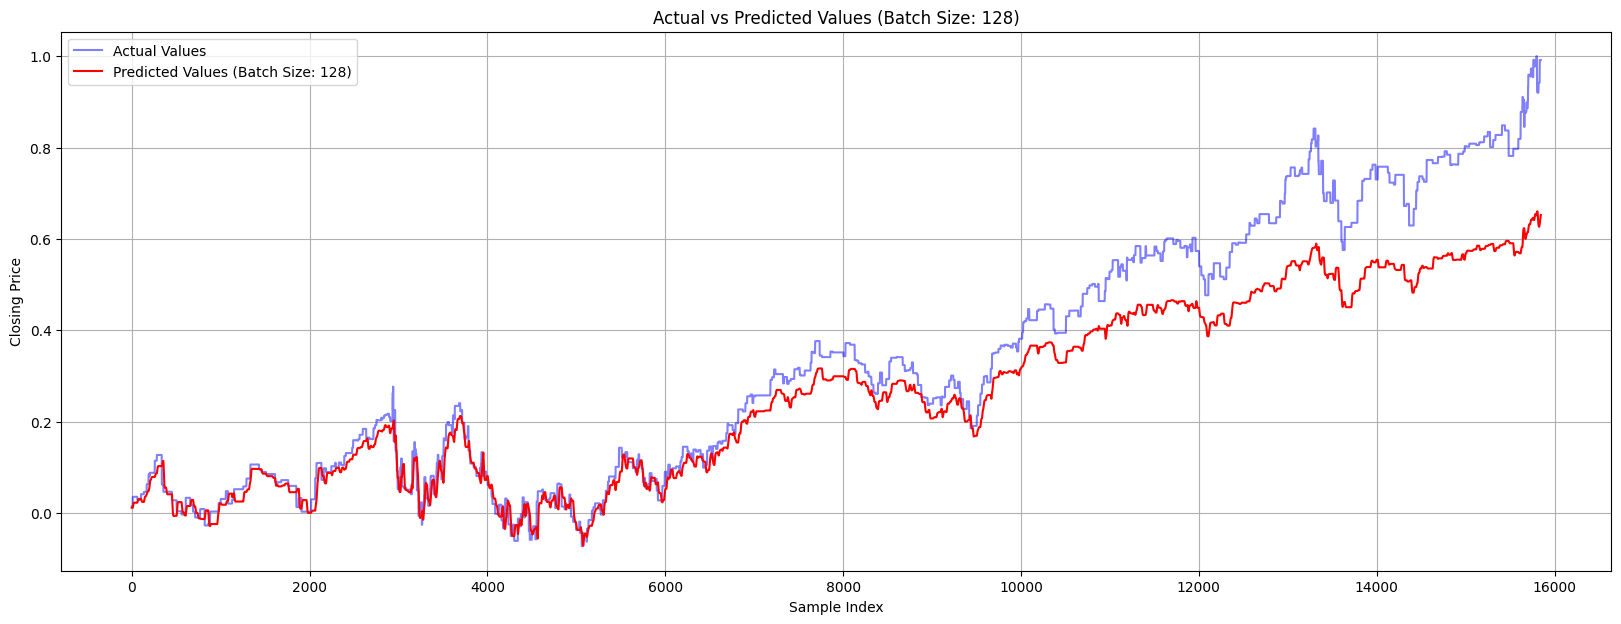

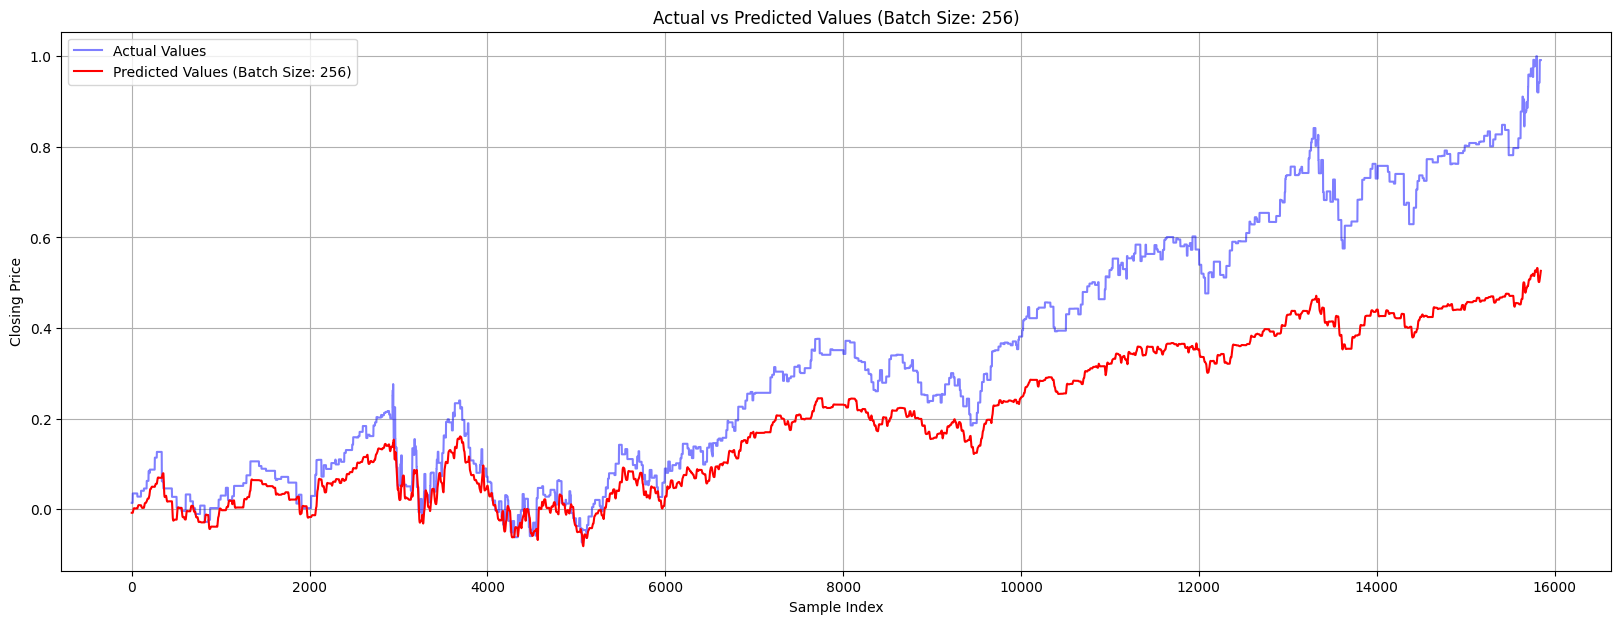

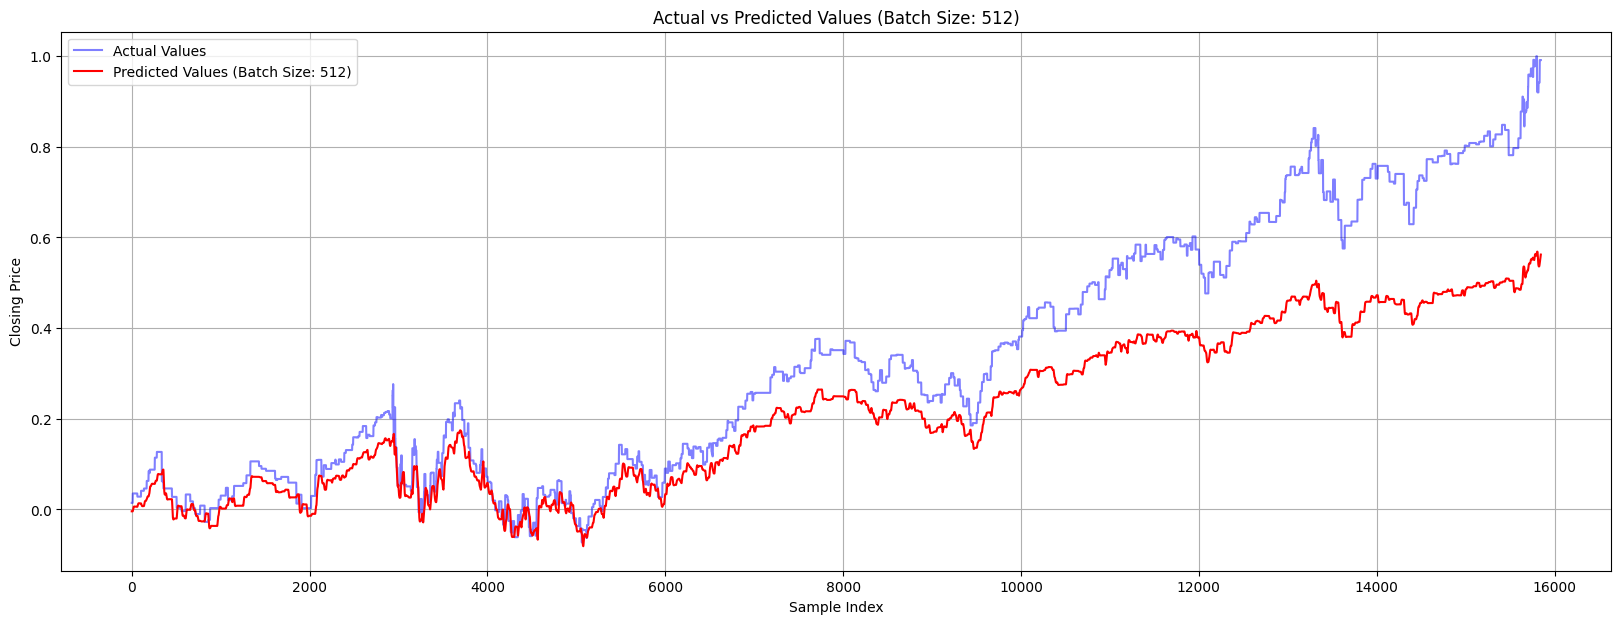

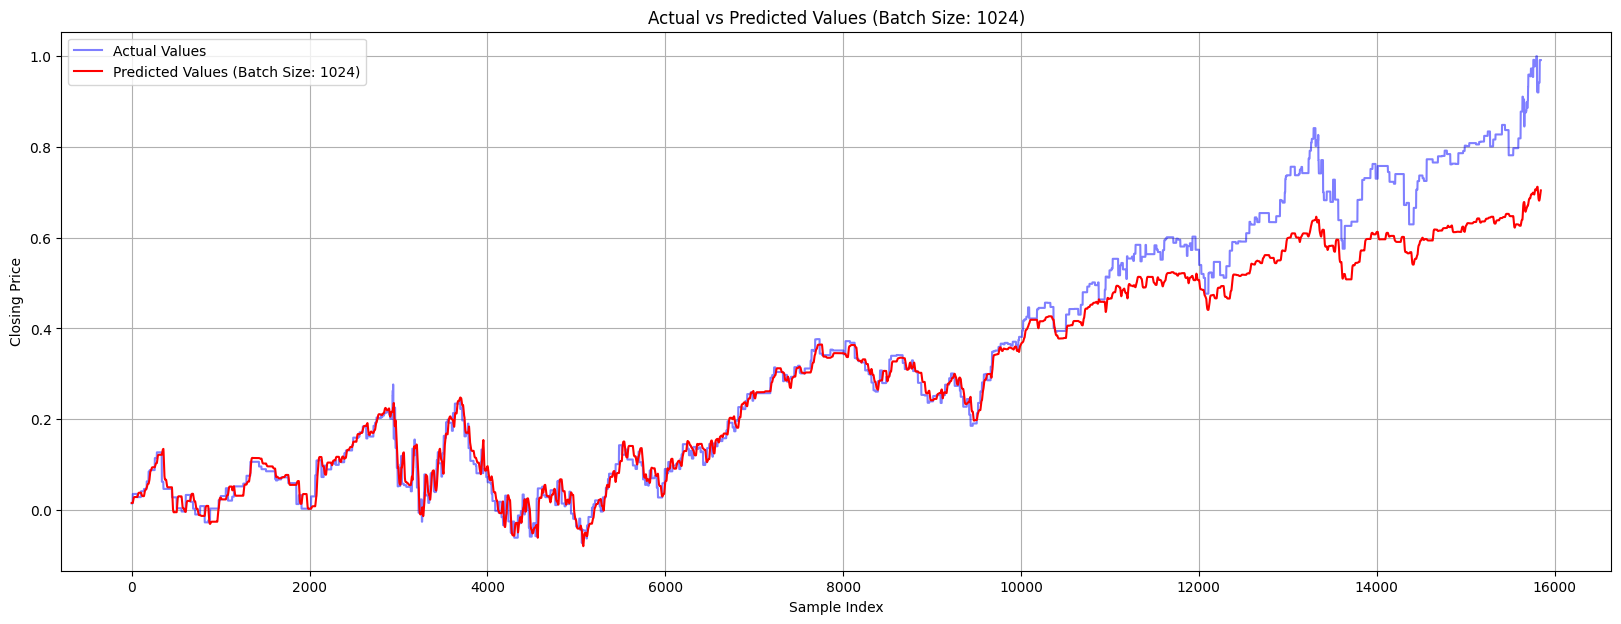

In [27]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

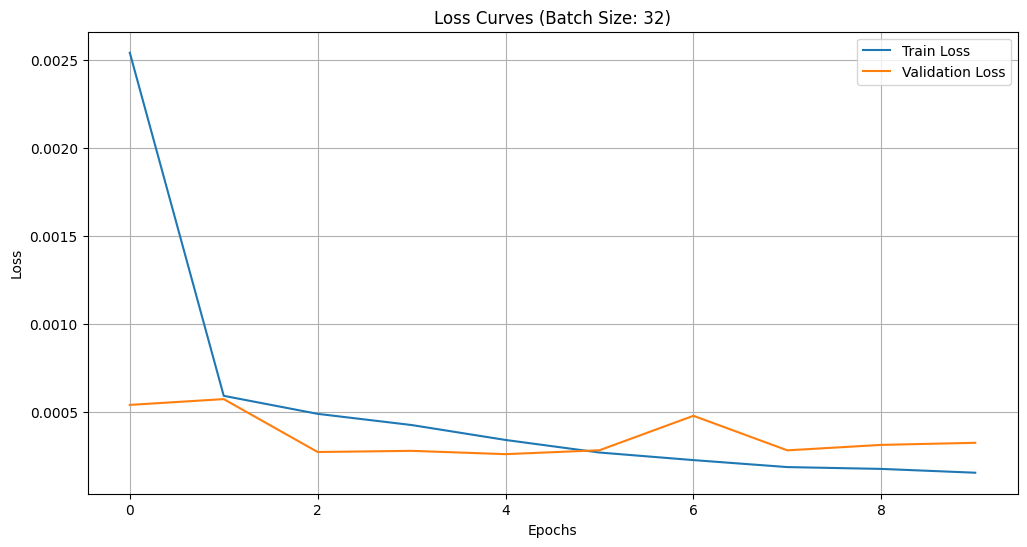

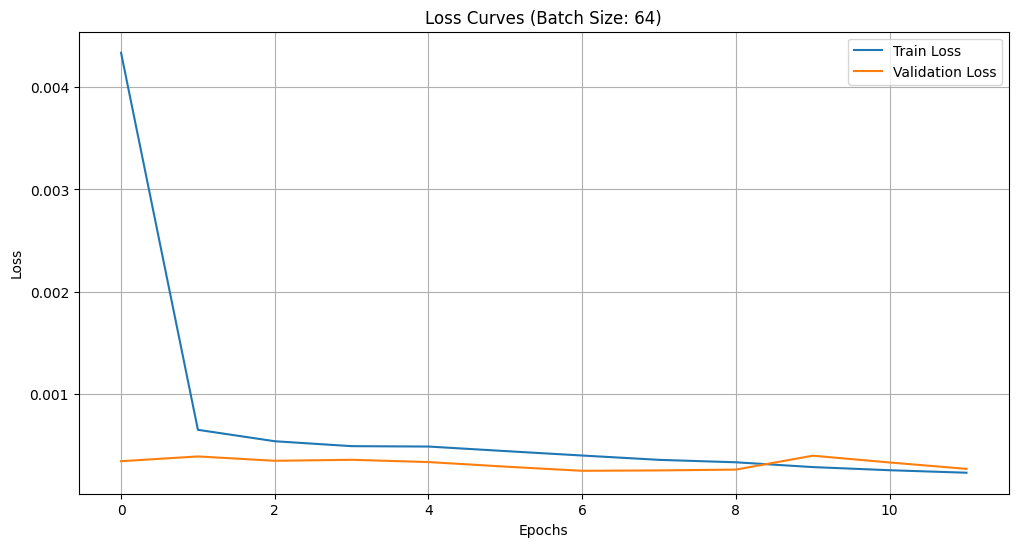

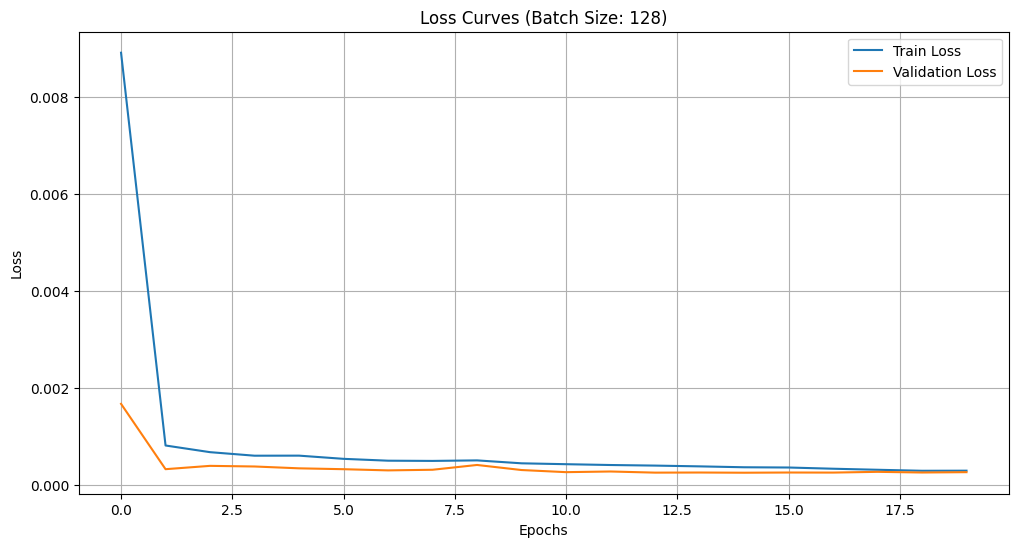

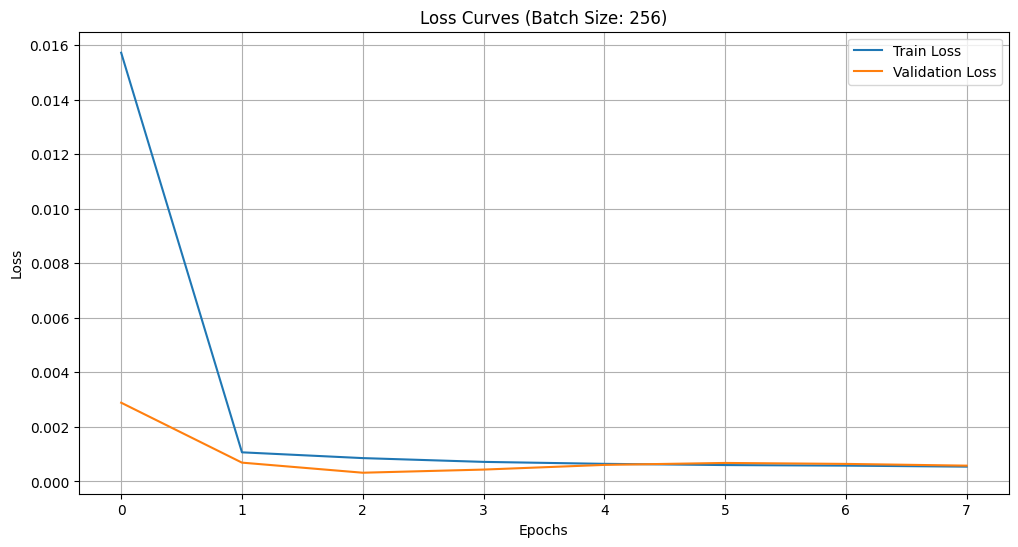

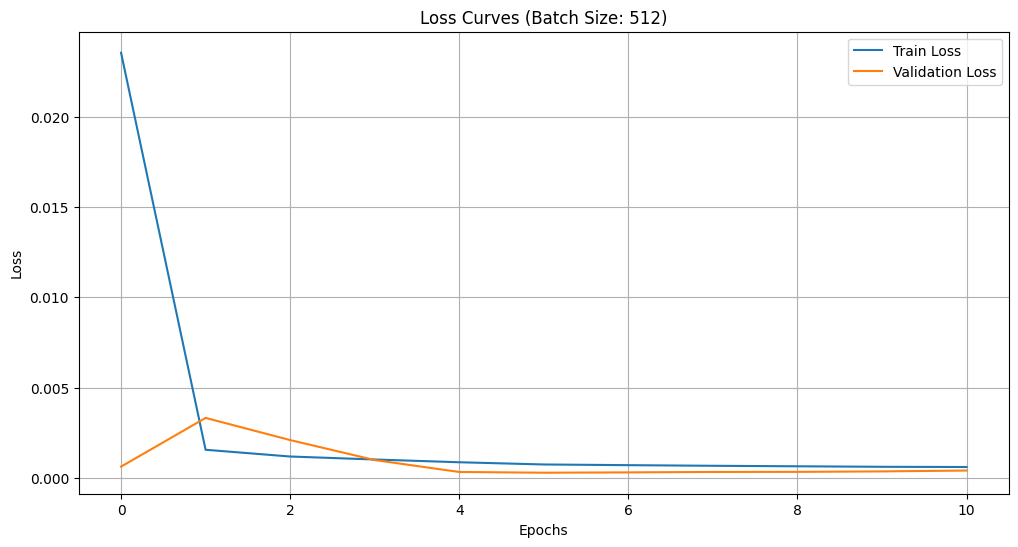

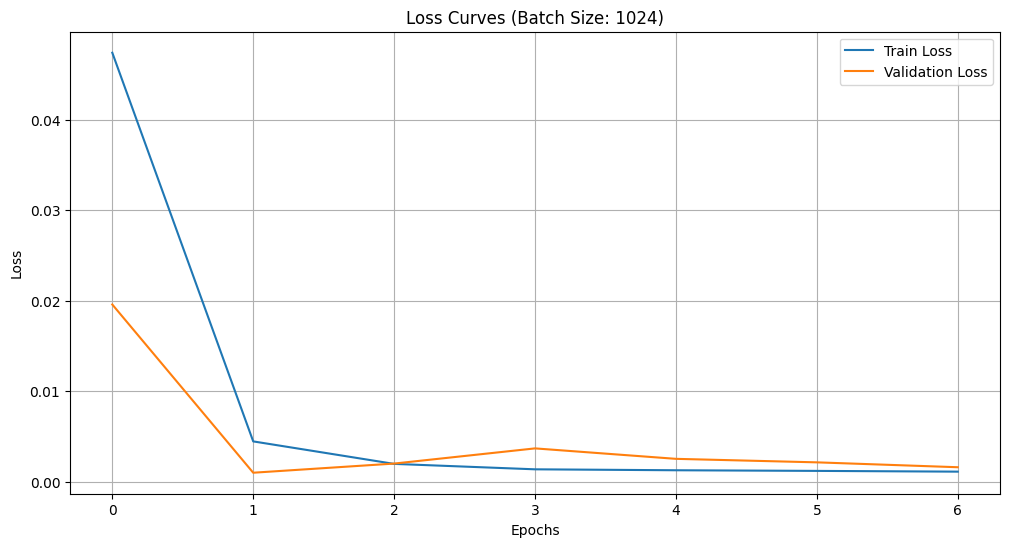

In [28]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close + VADER

In [ ]:
from sklearn.model_selection import train_test_split

past_vader = ['past_day_close', 'vader_sentiment']

X, y = create_dataset(df[past_vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close + RoBERTa

In [ ]:
from sklearn.model_selection import train_test_split

past_roberta = ['past_day_close', 'roberta_sentiment']

X, y = create_dataset(df[past_roberta].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close + VADER + RoBERTa

In [29]:
from sklearn.model_selection import train_test_split

past_sentiment = ['past_day_close', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[past_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [30]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 16, MSE: 0.021, RMSE: 0.144, R-squared: 0.629
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 32, MSE: 0.012, RMSE: 0.112, R-squared: 0.779
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 64, MSE: 0.015, RMSE: 0.122, R-squared: 0.734
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 128, MSE: 0.017, RMSE: 0.129, R-squared: 0.706
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 256, MSE: 0.054, RMSE: 0.232, R-squared: 0.045
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 512, MSE: 0.038, RMSE: 0.194, R-squared: 0.333
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 1024, MSE: 0.031, RMSE: 0.176, R-squared: 0.452


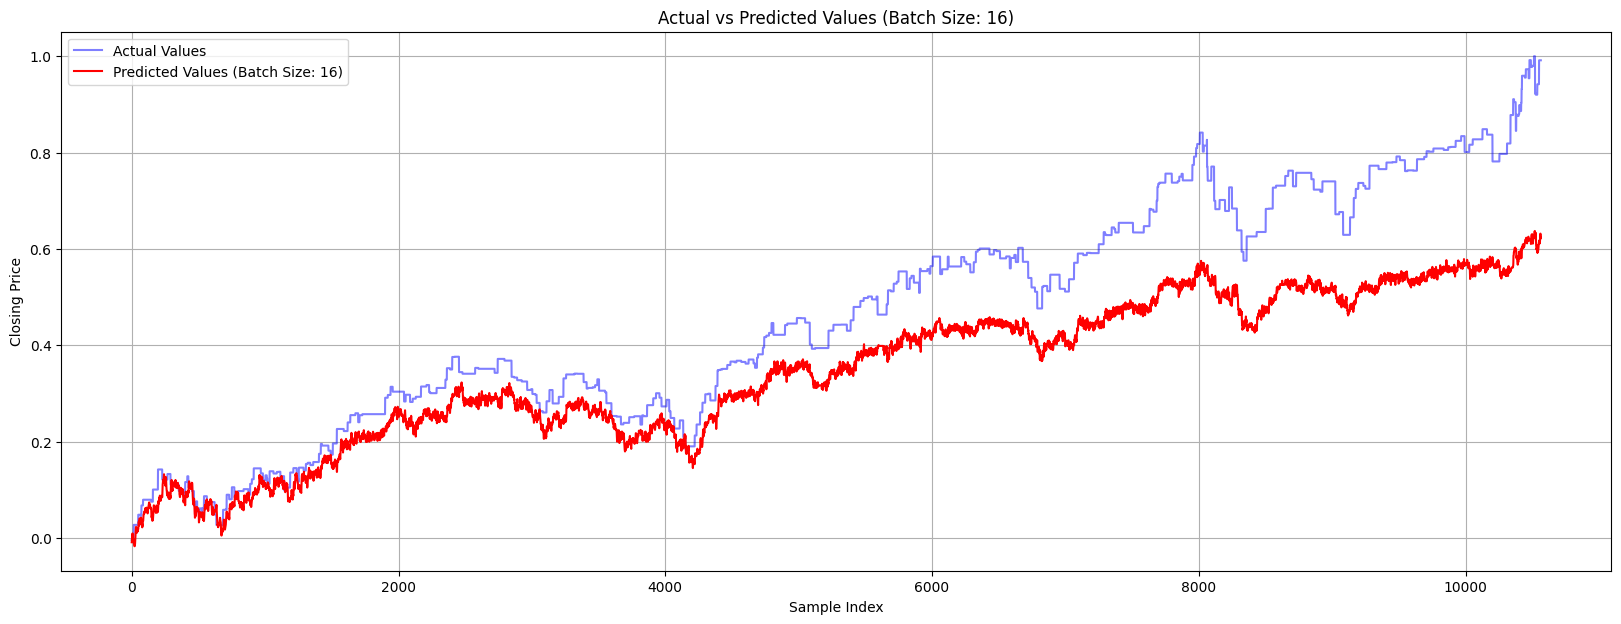

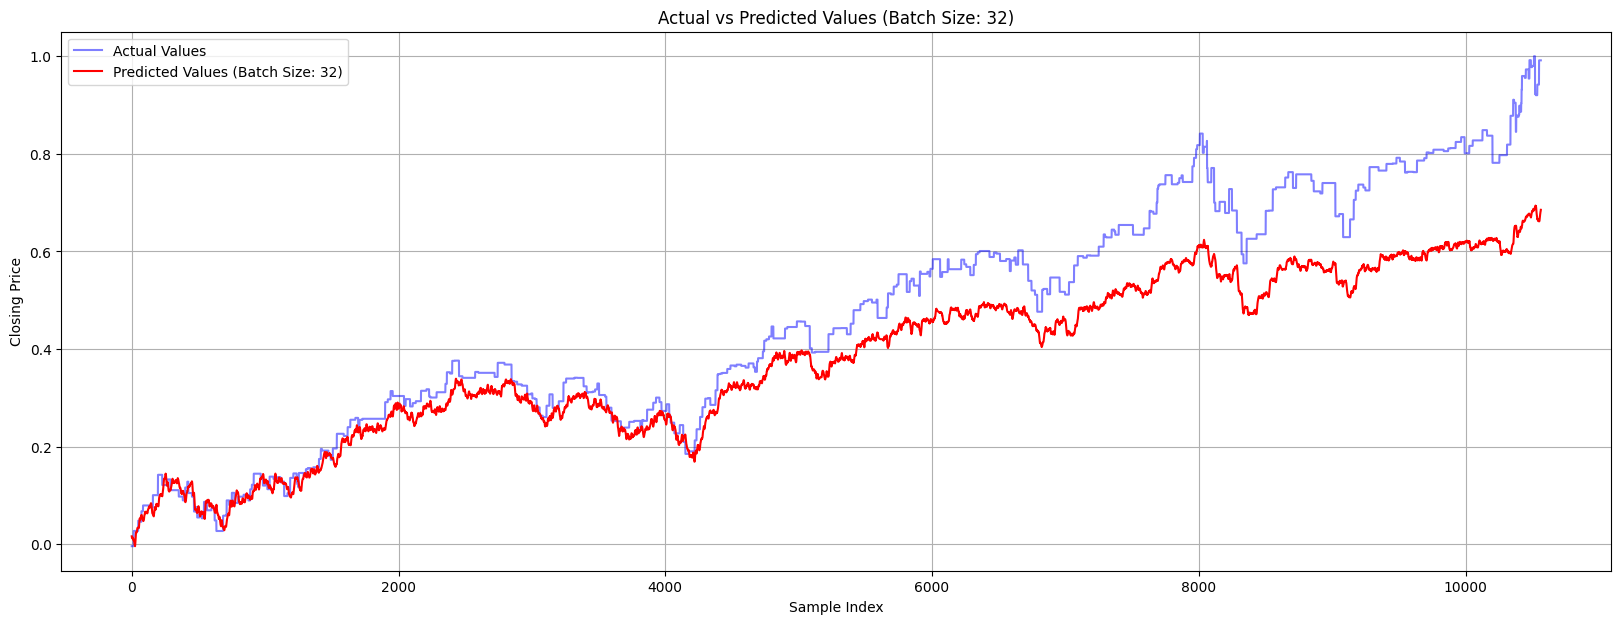

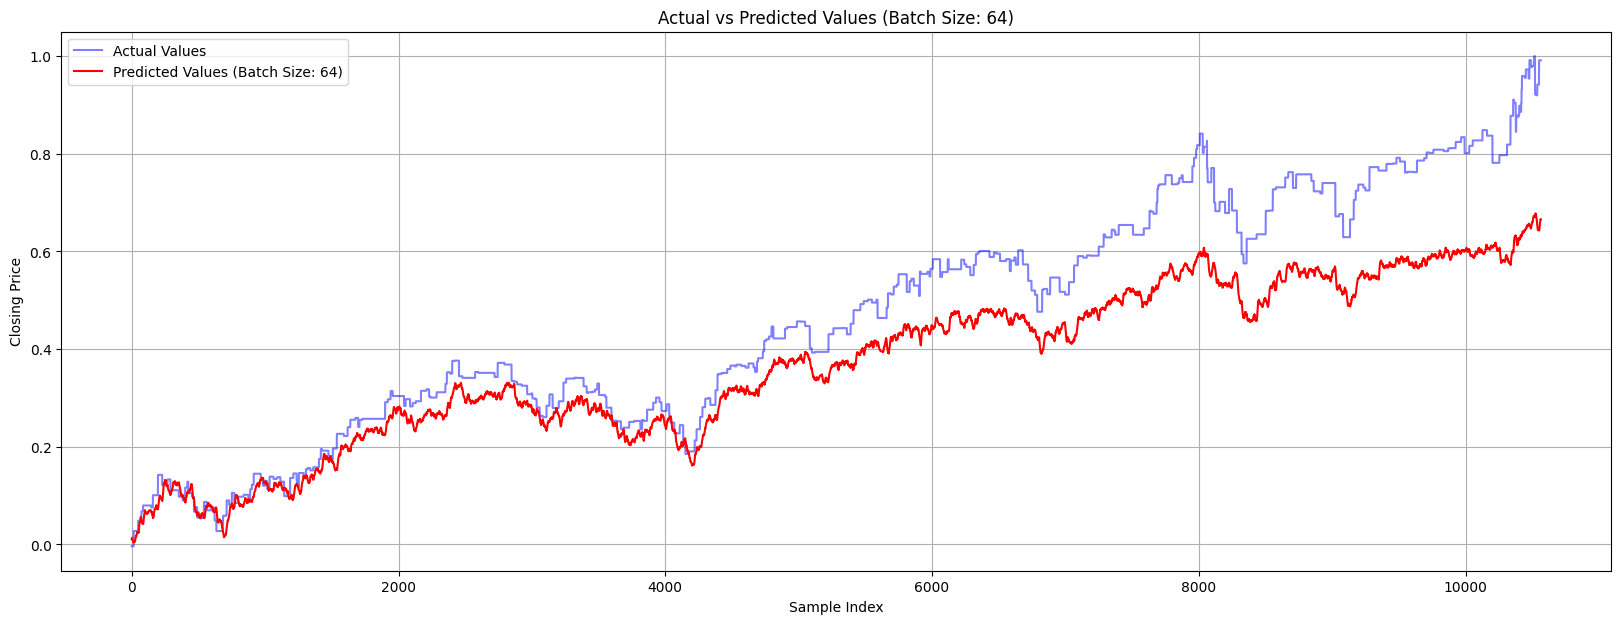

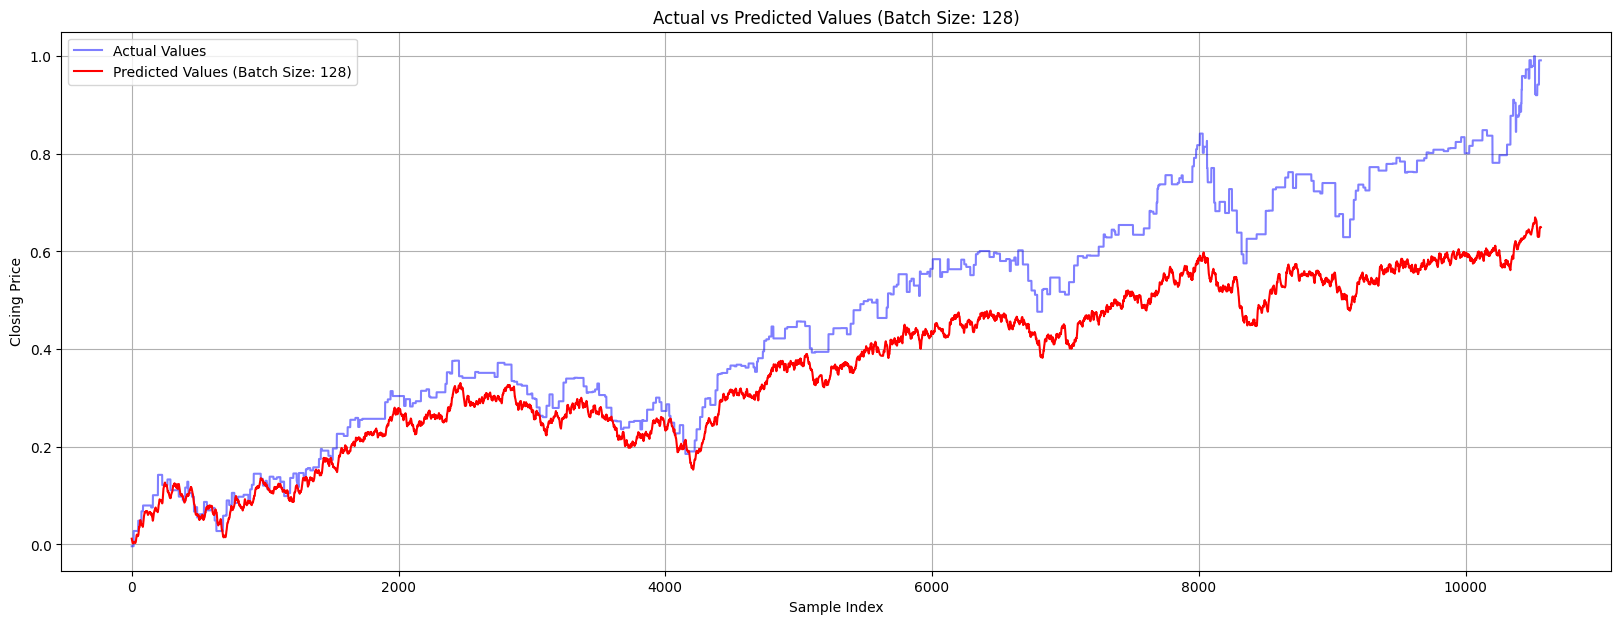

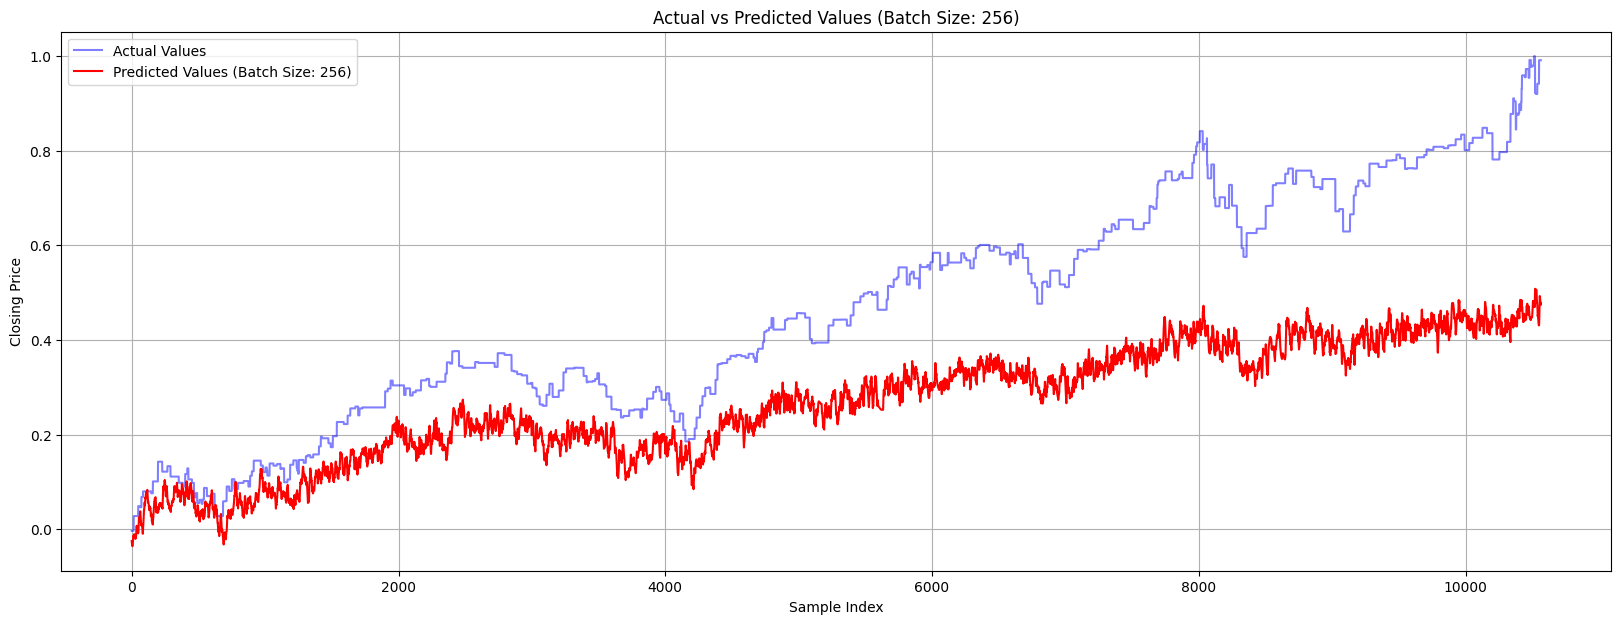

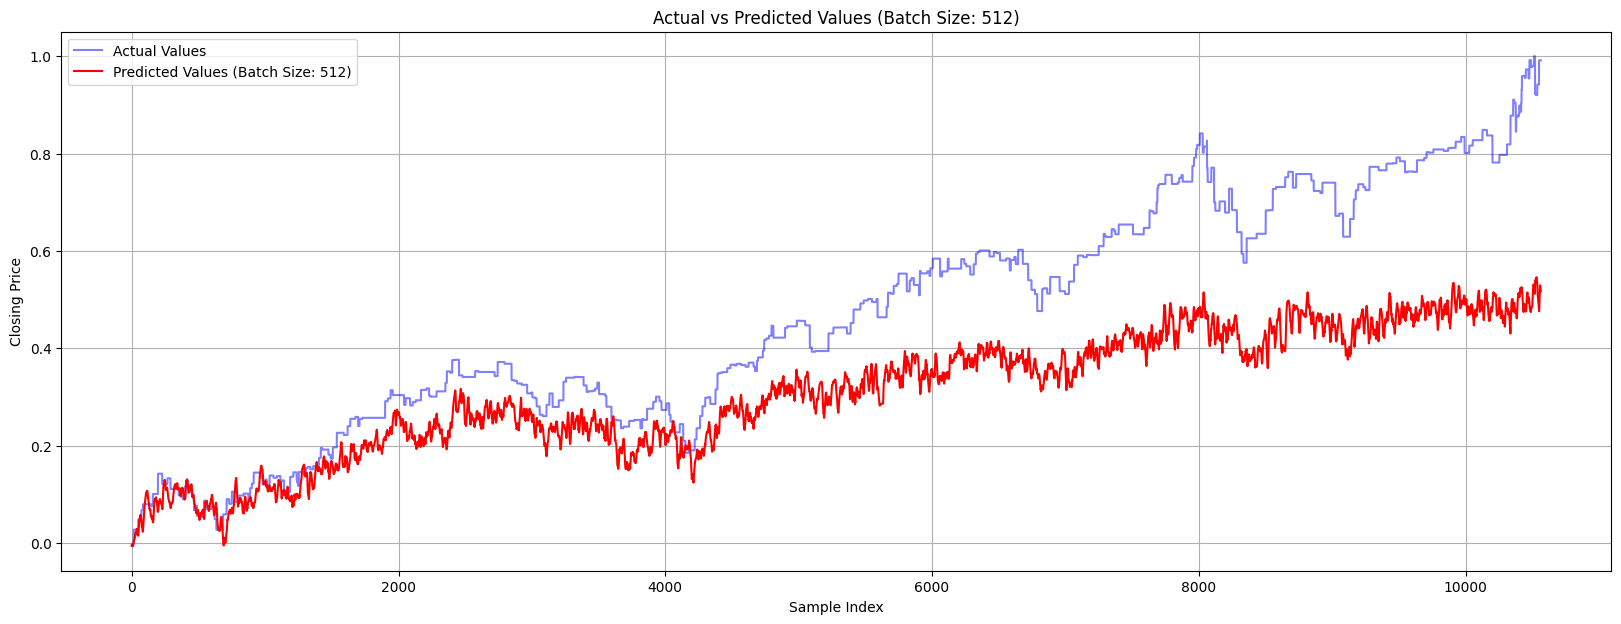

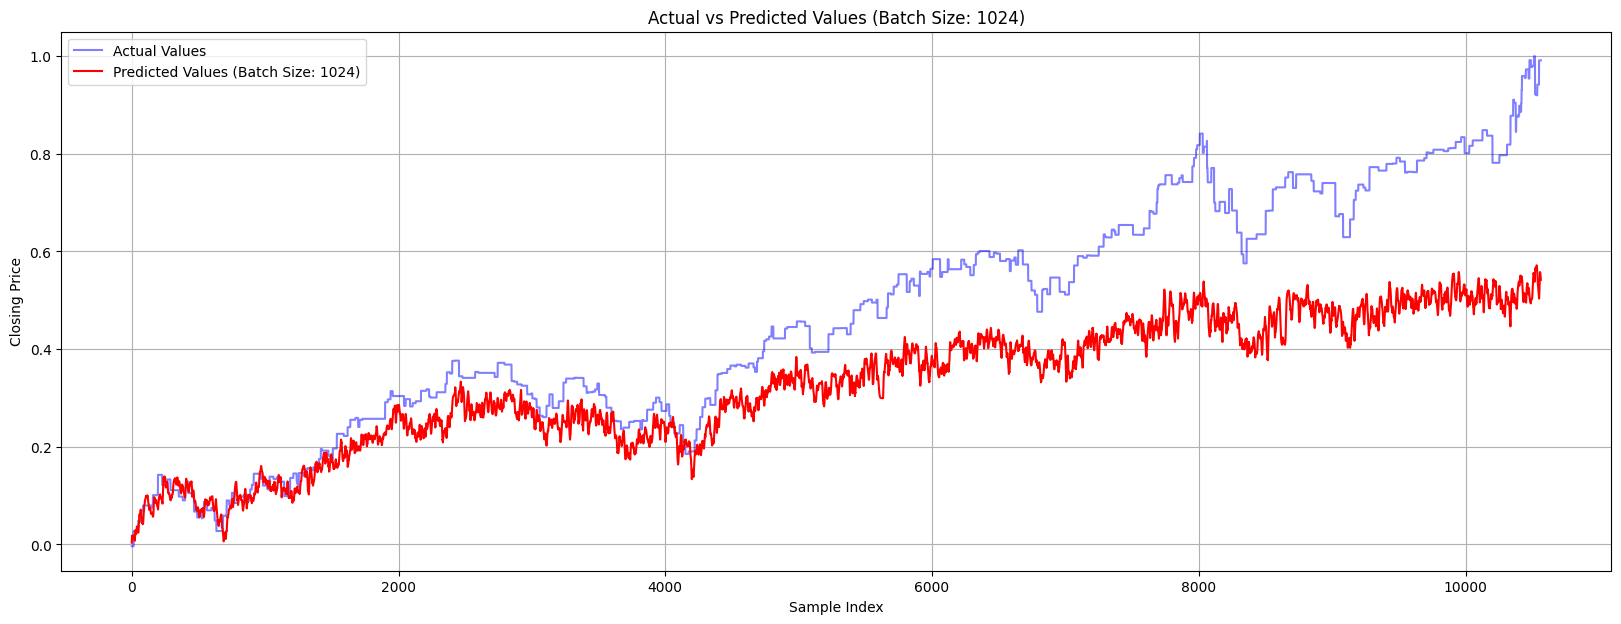

In [31]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

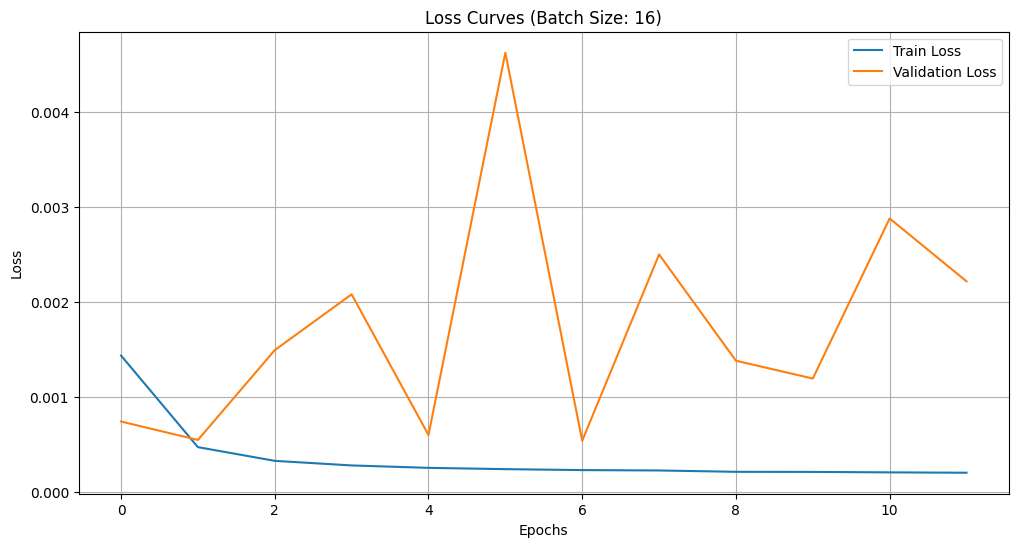

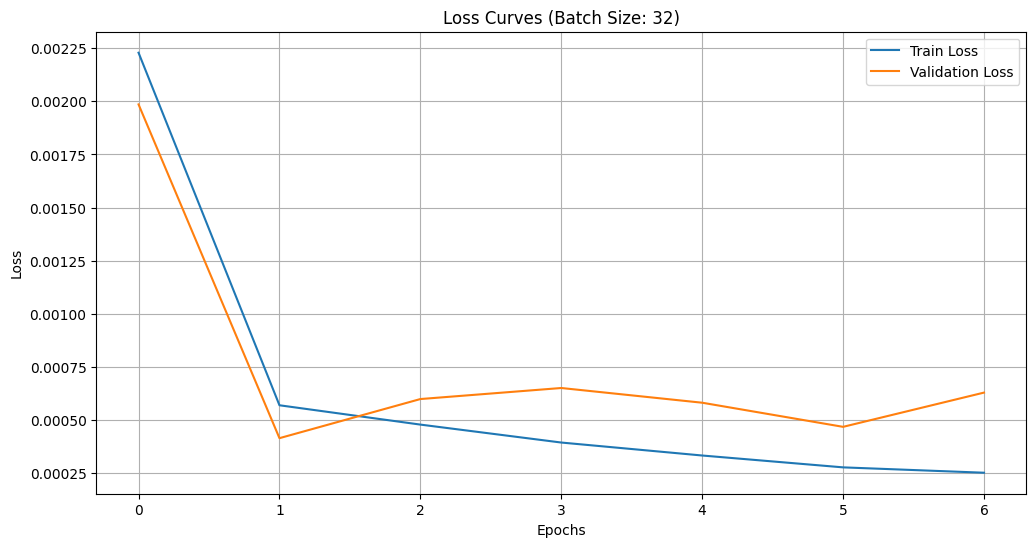

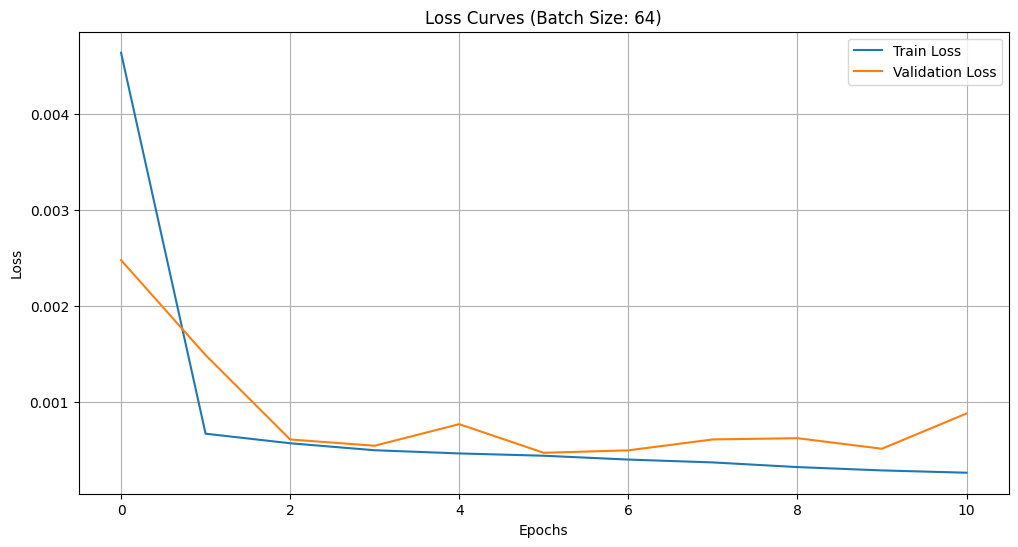

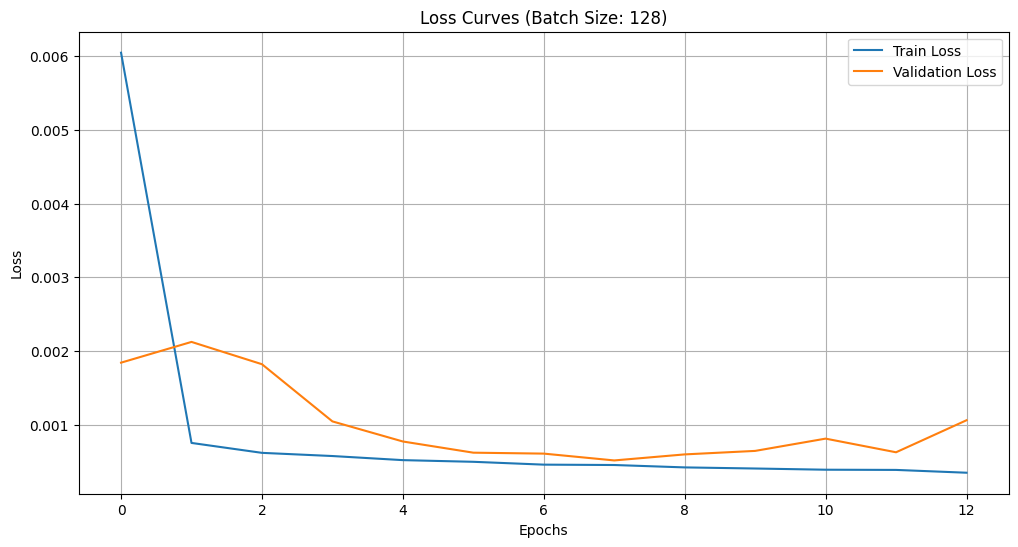

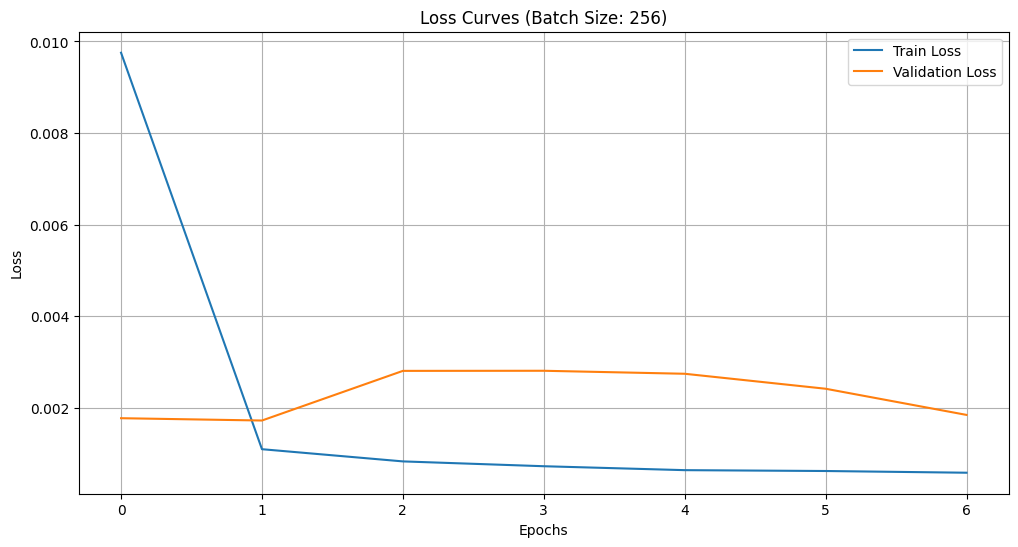

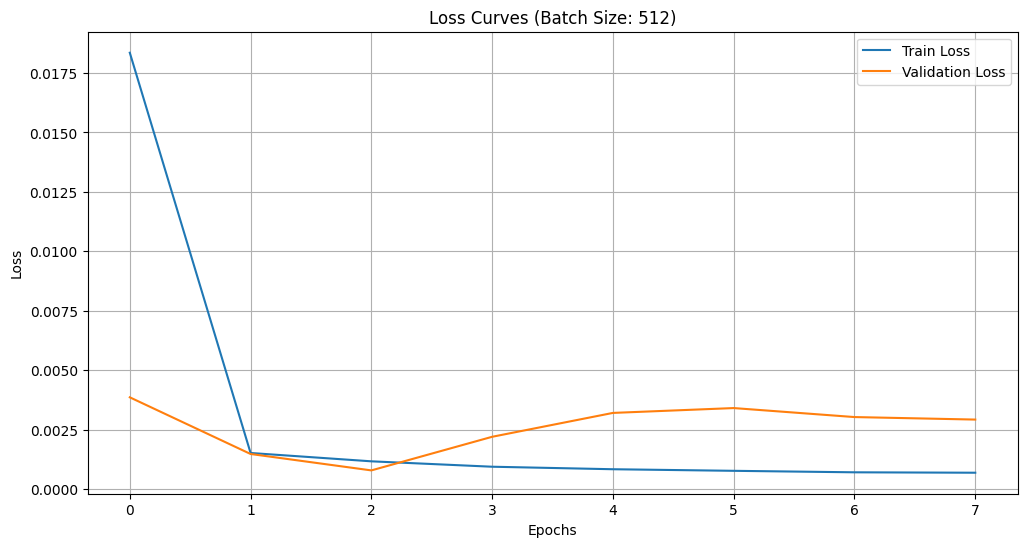

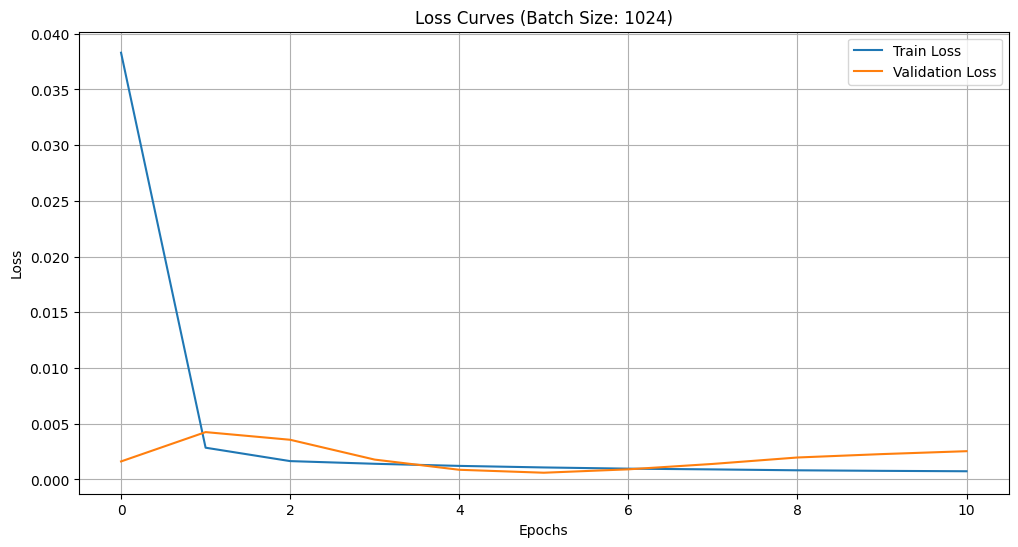

In [32]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume

In [ ]:
from sklearn.model_selection import train_test_split

nasdaq = ['Open', 'High', 'Low', 'Volume']

X, y = create_dataset(df[nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close

In [ ]:
from sklearn.model_selection import train_test_split

past_nasdaq = ['Open', 'High', 'Low', 'Volume', 'past_day_close']

X, y = create_dataset(df[past_nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close + VADER

In [ ]:
from sklearn.model_selection import train_test_split

past_nasdaq_vader = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'vader_sentiment']

X, y = create_dataset(df[past_nasdaq_vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close + RoBERTa

In [ ]:
from sklearn.model_selection import train_test_split

past_nasdaq_roberta = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq_roberta].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close + VADER + RoBERTa 

In [ ]:
from sklearn.model_selection import train_test_split

past_nasdaq_sentiment = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

In [ ]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()